# Laser CARP

In [1]:
# import modules
import sys
sys.path.insert(1, '../src')
from MPA_model import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
# parameters
INIT_WAVELENGTH = 800e-9 # in meter
INIT_PULSE_ENERGY = 1.2e-2 # in joule
INIT_PULSE_DURATION = 160e-12 # in seconds
INPUT_AREA = 1.8e-4 # in meter square

initial = SignalPacket(INIT_WAVELENGTH, INIT_PULSE_ENERGY, INPUT_AREA, INIT_PULSE_DURATION, 0, 0)

In [3]:
# pack time series single to signal_pile
initial_signal_pile = [[initial]]

In [4]:
# crystal parameters
CRYSTAL_ALPHA = 1.32e2 # attenuation in 
CRYSTAL_QD = 0.665 # quantum defect
CRYSTAL_LENGTH = 20e-3 # length in meter
CRYSTAL_N2 = 2.9e-20 # nonlinear refractive index in m^2/W
CRYSTAL_J_SAT = 0.9e4 # saturation fluence in J/m^2

# initiate crystal 1 object
crystal = Crystal(CRYSTAL_ALPHA, CRYSTAL_QD, CRYSTAL_LENGTH, CRYSTAL_N2, CRYSTAL_J_SAT)

In [5]:
# pump energy parameters
PUMP_ENERGY = 3.1 # in joule
PUMP_AREA =  2e-4 # in meter square
PUMP_ENERGY_DISTRIBUTION = 'beer'
PUMP_FRONT_PUMP = True
PUMP_BACK_PUMP = True

# initiate pump 1 object
pump = Pump(PUMP_ENERGY, PUMP_AREA)

In [6]:
# multipass amplifier (MPA) 2 parameters
MPA2_CRYSTAL_RESOLUTION = 20 # number of crystal splits
MPA2_NUMPASS = 3 # number of passes
MPA2_LOSS_PER_PATH = 0 # percent of energy loss per path

#initiate MPA 2
m = MultiPassAmplifier(crystal)
m.set_crystal_res(MPA2_CRYSTAL_RESOLUTION)
m.set_loss_per_path(MPA2_LOSS_PER_PATH)
m.clear_passes()

In [7]:
# calculate stored energy
store = m.calculate_stored_energy_from_pump(pump, PUMP_ENERGY_DISTRIBUTION, front_pump = PUMP_FRONT_PUMP, back_pump = PUMP_BACK_PUMP)

In [8]:
# amplify the signal
m.calculate_multi_pass_amplification(store, initial_signal_pile, MPA2_NUMPASS)
after_crystal_signal_pile = m.get_single_pass_output()

In [9]:
output = after_crystal_signal_pile[0][0]
print('output energy (J) : ' + str(output.E_in))

output energy (J) : 2.216329238804935


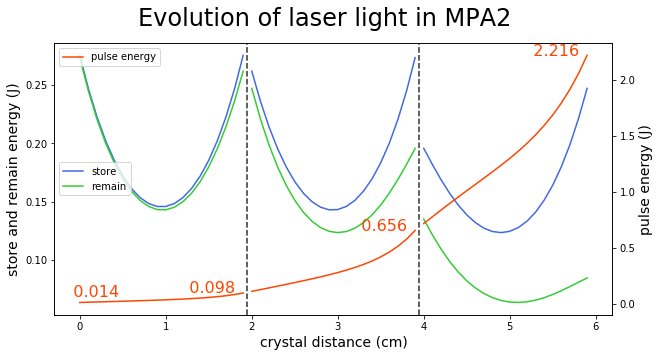

In [10]:
store_data = m.plot_multi_pass_store_energy()
remain_data = m.plot_multi_pass_remain_energy()

output_data = m.plot_multi_pass_output_energy()

fig, ax1 = plt.subplots(figsize = (10,5))

plot_multi_pass_data(ax1, MPA2_NUMPASS, [store_data, remain_data], ['royalblue', 'limegreen'], ['store', 'remain'], 1e2, 1, 'center left')
ax1.set_xlabel('crystal distance (cm)', fontsize  = 14)
ax1.set_ylabel('store and remain energy (J)', fontsize = 14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

plot_multi_pass_data(ax2, MPA2_NUMPASS, [output_data], ['orangered'], ['pulse energy'], 1e2, 1, 'best')
ax2.set_ylabel('pulse energy (J)', fontsize = 14)

output_x, output_y = output_data
val = output_y[0]
ax2.text(output_x[0] - 0.25, val + 0.05, "{0:8.3f}".format(val), c = 'orangered', fontsize = 16)
plot_multi_pass_last_value(ax2, MPA2_NUMPASS, output_data, 'orangered', '{0:8.3f}', 1e2, 1, -0.8, 0, 16)

fig.suptitle('Evolution of laser light in MPA2', fontsize = 24)
fig.savefig('../pics/laser_MPA2.png')
plt.show()

## Reflected light

In [11]:
REFLECTED_PERCENT = 0.01
reflected = output.copy()
reflected_energy = REFLECTED_PERCENT * output.E_in 
reflected.set_energy(reflected_energy)
print('Reflected energy (J) : ' + str(reflected.E_in))

Reflected energy (J) : 0.02216329238804935


In [12]:
after_amp_store = m.calculate_stored_energy_from_remain()
after_amp_store = np.flip(after_amp_store)

In [13]:
m1 = MultiPassAmplifier(crystal)
m1.set_crystal_res(MPA2_CRYSTAL_RESOLUTION)
m1.set_loss_per_path(0)
m1.clear_passes()

amp_reflected_signal_pile = m1.calculate_multi_pass_amplification(after_amp_store, [[reflected]], MPA2_NUMPASS)

In [14]:
amp_reflected = amp_reflected_signal_pile[0][0]
print('energy in reflected light after MPA2 (J) : ' + str(amp_reflected.E_in))

energy in reflected light after MPA2 (J) : 0.2835309015642232


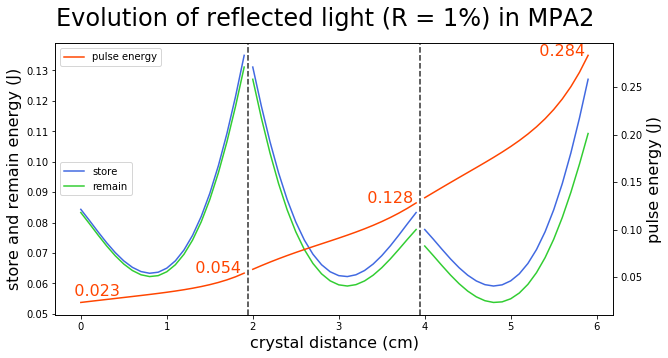

In [15]:
store_data = m1.plot_multi_pass_store_energy()
remain_data = m1.plot_multi_pass_remain_energy()

output_data = m1.plot_multi_pass_output_energy()

fig, ax1 = plt.subplots(figsize = (10,5))

plot_multi_pass_data(ax1, MPA2_NUMPASS, [store_data, remain_data], ['royalblue', 'limegreen'], ['store', 'remain'], 1e2, 1, 'center left')
ax1.set_xlabel('crystal distance (cm)', fontsize  = 16)
ax1.set_ylabel('store and remain energy (J)', fontsize = 16)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

plot_multi_pass_data(ax2, MPA2_NUMPASS, [output_data], ['orangered'], ['pulse energy'], 1e2, 1, 'best')
ax2.set_ylabel('pulse energy (J)', fontsize = 16)

output_x, output_y = output_data
val = output_y[0]
ax2.text(output_x[0] - 0.25, val + 0.0075, "{0:8.3f}".format(val), c = 'orangered', fontsize = 16)
plot_multi_pass_last_value(ax2, MPA2_NUMPASS, output_data, 'orangered', '{0:8.3f}', 1e2, 1, -0.75, 0, 16)

fig.suptitle('Evolution of reflected light (R = 1%) in MPA2', fontsize = 24)
fig.savefig('../pics/reflected_MPA2.png')
plt.show()

## Introducing CARP

In [16]:
# parameters
CARP_WAVELENGTH = 800e-9 # in meter
CARP_PULSE_ENERGY = 100e-3 # in joule
CARP_PULSE_DURATION = 6e-9 # in seconds
CARP_AREA = 2e-4 # in meter square

initial_carp = SignalPacket(CARP_WAVELENGTH, CARP_PULSE_ENERGY, CARP_AREA, CARP_PULSE_DURATION, 0, 0)

In [17]:
CARP_NUMPASS = 5

m2 = MultiPassAmplifier(crystal)
m2.set_crystal_res(MPA2_CRYSTAL_RESOLUTION)
m2.set_loss_per_path(0)
m2.clear_passes()

after_amp_store = np.flip(after_amp_store)

output_carp_signal_pile = m2.calculate_multi_pass_amplification(after_amp_store, [[initial_carp]], CARP_NUMPASS)

In [18]:
output_carp = output_carp_signal_pile[0][0]
print('energy in carp after MPA2 (J) : ' + str(output_carp.E_in))

energy in carp after MPA2 (J) : 1.507838502803249


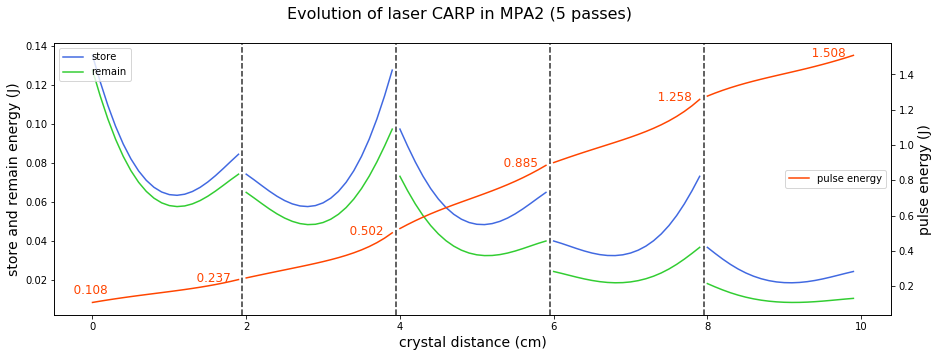

In [19]:
store_data = m2.plot_multi_pass_store_energy()
remain_data = m2.plot_multi_pass_remain_energy()

output_data = m2.plot_multi_pass_output_energy()

fig, ax1 = plt.subplots(figsize = (15,5))

plot_multi_pass_data(ax1, CARP_NUMPASS, [store_data, remain_data], ['royalblue', 'limegreen'], ['store', 'remain'], 1e2, 1, 'upper left')
ax1.set_xlabel('crystal distance (cm)', fontsize  = 14)
ax1.set_ylabel('store and remain energy (J)', fontsize = 14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

plot_multi_pass_data(ax2, CARP_NUMPASS, [output_data], ['orangered'], ['pulse energy'], 1e2, 1, 'right')
ax2.set_ylabel('pulse energy (J)', fontsize = 14)

output_x, output_y = output_data
val = output_y[0]
ax2.text(output_x[0] - 0.4, val + 0.05, "{0:8.3f}".format(val), c = 'orangered', fontsize = 12)
plot_multi_pass_last_value(ax2, CARP_NUMPASS, output_data, 'orangered', '{0:8.3f}', 1e2, 1, -0.7, -0.01, 12)

fig.suptitle('Evolution of laser CARP in MPA2 (5 passes)', fontsize = 16)
fig.savefig('../pics/carp_MPA2.png')
plt.show()

In [20]:
print('Reflected energy (J) : ' + str(reflected.E_in))

Reflected energy (J) : 0.02216329238804935


In [21]:
after_carp_store = m2.calculate_stored_energy_from_remain()
after_carp_store = np.flip(after_carp_store)

In [22]:
m3 = MultiPassAmplifier(crystal)
m3.set_crystal_res(MPA2_CRYSTAL_RESOLUTION)
m3.set_loss_per_path(0)
m3.clear_passes()

output_reflected_carp_signal_pile = m3.calculate_multi_pass_amplification(after_carp_store, [[reflected]], MPA2_NUMPASS)

In [23]:
output_reflected_carp = output_reflected_carp_signal_pile[0][0]
print('energy in carp after MPA2 (J) : ' + str(output_reflected_carp.E_in))

energy in carp after MPA2 (J) : 0.03155359712388935


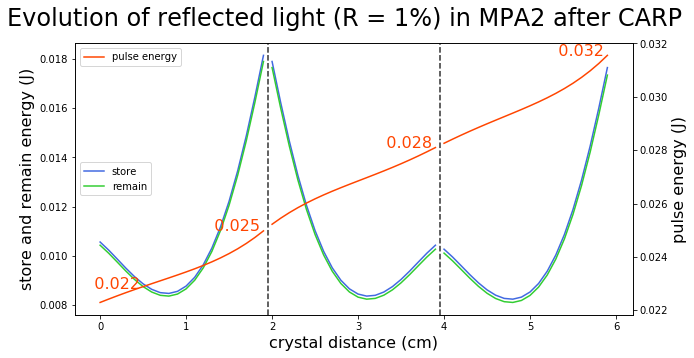

In [24]:
store_data = m3.plot_multi_pass_store_energy()
remain_data = m3.plot_multi_pass_remain_energy()

output_data = m3.plot_multi_pass_output_energy()

fig, ax1 = plt.subplots(figsize = (10,5))

plot_multi_pass_data(ax1, MPA2_NUMPASS, [store_data, remain_data], ['royalblue', 'limegreen'], ['store', 'remain'], 1e2, 1, 'center left')
ax1.set_xlabel('crystal distance (cm)', fontsize  = 16)
ax1.set_ylabel('store and remain energy (J)', fontsize = 16)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

plot_multi_pass_data(ax2, MPA2_NUMPASS, [output_data], ['orangered'], ['pulse energy'], 1e2, 1, 'best')
ax2.set_ylabel('pulse energy (J)', fontsize = 16)

output_x, output_y = output_data
val = output_y[0]
ax2.text(output_x[0] - 0.25, val + 0.0005, "{0:8.3f}".format(val), c = 'orangered', fontsize = 16)
plot_multi_pass_last_value(ax2, MPA2_NUMPASS, output_data, 'orangered', '{0:8.3f}', 1e2, 1, -0.75, 0, 16)

fig.suptitle('Evolution of reflected light (R = 1%) in MPA2 after CARP', fontsize = 24)
fig.savefig('../pics/reflected_carp_MPA2.png')
plt.show()
